In [1]:
import os
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
zip_file = keras.utils.get_file(
    fname="cora.tgz",
    origin="https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz",
    extract=True,
)
data_dir = os.path.join(os.path.dirname(zip_file), "cora")

In [3]:
citations = pd.read_csv(
    os.path.join(data_dir, "cora.cites"),
    sep="\t",
    header=None,
    names=["target", "source"],
)
print("Citations shape:", citations.shape)

Citations shape: (5429, 2)


In [4]:
citations.sample(frac=1).head()

,target,source
2533,27535,1112026
517,1952,1111899
5312,671269,1154124
4394,177998,583318
1675,10177,10169


In [5]:
column_names = ["paper_id"] + [f"term_{idx}" for idx in range(1433)] + ["subject"]
papers = pd.read_csv(
    os.path.join(data_dir, "cora.content"), sep="\t", header=None, names=column_names,
)
print("Papers shape:", papers.shape)

Papers shape: (2708, 1435)


In [6]:
print(papers.sample(5).T)

                            2323        1040           1081  \
paper_id                 1152633     1130657         135765   
term_0                         0           0              0   
term_1                         0           0              0   
term_2                         0           0              0   
term_3                         0           0              0   
term_4                         0           0              0   
term_5                         0           0              0   
term_6                         0           0              0   
term_7                         0           0              0   
term_8                         0           0              0   
term_9                         0           0              0   
term_10                        0           0              0   
term_11                        0           0              0   
term_12                        0           0              0   
term_13                        0           0           

In [7]:
print(papers.subject.value_counts())

Neural_Networks           818
Probabilistic_Methods     426
Genetic_Algorithms        418
Theory                    351
Case_Based                298
Reinforcement_Learning    217
Rule_Learning             180
Name: subject, dtype: int64


In [8]:
class_values = sorted(papers["subject"].unique())
class_idx = {name: id for id, name in enumerate(class_values)}
paper_idx = {name: idx for idx, name in enumerate(sorted(papers["paper_id"].unique()))}

papers["paper_id"] = papers["paper_id"].apply(lambda name: paper_idx[name])
citations["source"] = citations["source"].apply(lambda name: paper_idx[name])
citations["target"] = citations["target"].apply(lambda name: paper_idx[name])
papers["subject"] = papers["subject"].apply(lambda value: class_idx[value])

In [9]:
train_data, test_data = [], []

for _, group_data in papers.groupby("subject"):
    # Select around 50% of the dataset for training.
    random_selection = np.random.rand(len(group_data.index)) <= 0.5
    train_data.append(group_data[random_selection])
    test_data.append(group_data[~random_selection])

train_data = pd.concat(train_data).sample(frac=1)
test_data = pd.concat(test_data).sample(frac=1)

print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

Train data shape: (1398, 1435)
Test data shape: (1310, 1435)


In [10]:
hidden_units = [32]
learning_rate = 0.01
dropout_rate = 0.5
num_epochs = 300
batch_size = 256

In [11]:
def run_experiment(model, x_train, y_train):
    # Compile the model.
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
    )
    # Create an early stopping callback.
    early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_acc", patience=50, restore_best_weights=True
    )
    # Fit the model.
    history = model.fit(
        x=x_train,
        y=y_train,
        epochs=num_epochs,
        batch_size=batch_size,
        validation_split=0.15,
        callbacks=[early_stopping],
    )

    return history

In [12]:
def display_learning_curves(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history.history["loss"])
    ax1.plot(history.history["val_loss"])
    ax1.legend(["train", "test"], loc="upper right")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")

    ax2.plot(history.history["acc"])
    ax2.plot(history.history["val_acc"])
    ax2.legend(["train", "test"], loc="upper right")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    plt.show()

In [13]:
def create_ffn(hidden_units, dropout_rate, name=None):
    fnn_layers = []

    for units in hidden_units:
        fnn_layers.append(layers.BatchNormalization())
        fnn_layers.append(layers.Dropout(dropout_rate))
        fnn_layers.append(layers.Dense(units, activation=tf.nn.gelu))

    return keras.Sequential(fnn_layers, name=name)

In [14]:
feature_names = set(papers.columns) - {"paper_id", "subject"}
num_features = len(feature_names)
num_classes = len(class_idx)

# Create train and test features as a numpy array.
x_train = train_data[feature_names].to_numpy()
x_test = test_data[feature_names].to_numpy()
# Create train and test targets as a numpy array.
y_train = train_data["subject"]
y_test = test_data["subject"]

In [15]:
def create_baseline_model(hidden_units, num_classes, dropout_rate=0.2):
    inputs = layers.Input(shape=(num_features,), name="input_features")
    x = create_ffn(hidden_units, dropout_rate, name=f"ffn_block1")(inputs)
    for block_idx in range(4):
        # Create an FFN block.
        x1 = create_ffn(hidden_units, dropout_rate, name=f"ffn_block{block_idx + 2}")(x)
        # Add skip connection.
        x = layers.Add(name=f"skip_connection{block_idx + 2}")([x, x1])
    # Compute logits.
    logits = layers.Dense(num_classes, name="logits")(x)
    # Create the model.
    return keras.Model(inputs=inputs, outputs=logits, name="baseline")


baseline_model = create_baseline_model(hidden_units, num_classes, dropout_rate)
baseline_model.summary()

Model: "baseline"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_features (InputLayer)     [(None, 1433)]       0                                            
__________________________________________________________________________________________________
ffn_block1 (Sequential)         (None, 32)           51620       input_features[0][0]             
__________________________________________________________________________________________________
ffn_block2 (Sequential)         (None, 32)           1184        ffn_block1[0][0]                 
__________________________________________________________________________________________________
skip_connection2 (Add)          (None, 32)           0           ffn_block1[0][0]                 
                                                                 ffn_block2[0][0]          

In [16]:
history = run_experiment(baseline_model, x_train, y_train)

Epoch 1/300
5/5 [==============================] - 2s 147ms/step - loss: 4.1215 - acc: 0.1848 - val_loss: 1.9767 - val_acc: 0.1762
Epoch 2/300
5/5 [==============================] - 0s 27ms/step - loss: 2.1075 - acc: 0.3595 - val_loss: 1.8277 - val_acc: 0.4048
Epoch 3/300
5/5 [==============================] - 0s 29ms/step - loss: 1.4337 - acc: 0.5175 - val_loss: 1.7435 - val_acc: 0.3714
Epoch 4/300
5/5 [==============================] - 0s 26ms/step - loss: 1.1337 - acc: 0.6159 - val_loss: 1.6293 - val_acc: 0.4333
Epoch 5/300
5/5 [==============================] - 0s 24ms/step - loss: 0.8884 - acc: 0.6993 - val_loss: 1.4341 - val_acc: 0.6286
Epoch 6/300
5/5 [==============================] - 0s 22ms/step - loss: 0.7634 - acc: 0.7311 - val_loss: 1.3192 - val_acc: 0.6381
Epoch 7/300
5/5 [==============================] - 0s 23ms/step - loss: 0.6039 - acc: 0.8041 - val_loss: 1.3009 - val_acc: 0.5857
Epoch 8/300
5/5 [==============================] - 0s 24ms/step - loss: 0.5640 - acc: 0.8

5/5 [==============================] - 0s 26ms/step - loss: 0.2229 - acc: 0.9234 - val_loss: 0.8881 - val_acc: 0.6952
Epoch 64/300
5/5 [==============================] - 0s 21ms/step - loss: 0.1948 - acc: 0.9341 - val_loss: 0.8754 - val_acc: 0.6857
Epoch 65/300
5/5 [==============================] - 0s 21ms/step - loss: 0.2064 - acc: 0.9194 - val_loss: 0.8530 - val_acc: 0.7238
Epoch 66/300
5/5 [==============================] - 0s 22ms/step - loss: 0.2292 - acc: 0.9281 - val_loss: 0.8793 - val_acc: 0.7095
Epoch 67/300
5/5 [==============================] - 0s 22ms/step - loss: 0.2023 - acc: 0.9364 - val_loss: 0.8920 - val_acc: 0.7143
Epoch 68/300
5/5 [==============================] - 0s 22ms/step - loss: 0.2431 - acc: 0.9187 - val_loss: 0.8594 - val_acc: 0.7000
Epoch 69/300
5/5 [==============================] - 0s 22ms/step - loss: 0.2117 - acc: 0.9303 - val_loss: 0.8661 - val_acc: 0.7000
Epoch 70/300
5/5 [==============================] - 0s 21ms/step - loss: 0.2515 - acc: 0.9221 - 

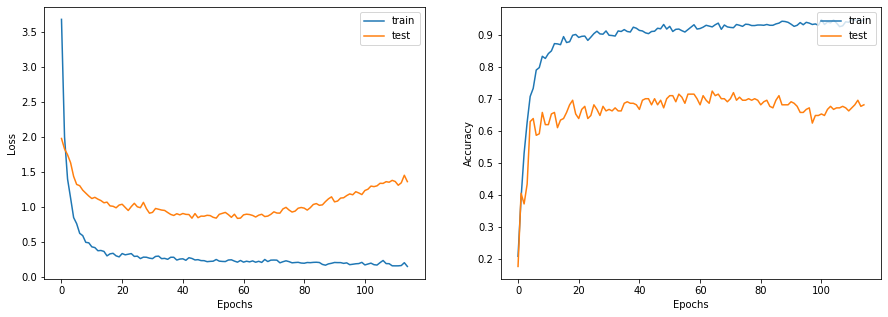

In [17]:
display_learning_curves(history)

In [18]:
_, test_accuracy = baseline_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 71.68%


In [19]:
def generate_random_instances(num_instances):
    token_probability = x_train.mean(axis=0)
    instances = []
    for _ in range(num_instances):
        probabilities = np.random.uniform(size=len(token_probability))
        instance = (probabilities <= token_probability).astype(int)
        instances.append(instance)

    return np.array(instances)


def display_class_probabilities(probabilities):
    for instance_idx, probs in enumerate(probabilities):
        print(f"Instance {instance_idx + 1}:")
        for class_idx, prob in enumerate(probs):
            print(f"- {class_values[class_idx]}: {round(prob * 100, 2)}%")

In [20]:
new_instances = generate_random_instances(num_classes)
logits = baseline_model.predict(new_instances)
probabilities = keras.activations.softmax(tf.convert_to_tensor(logits)).numpy()
display_class_probabilities(probabilities)

Instance 1:
- Case_Based: 7.96%
- Genetic_Algorithms: 6.8%
- Neural_Networks: 13.1%
- Probabilistic_Methods: 50.33%
- Reinforcement_Learning: 3.32%
- Rule_Learning: 15.37%
- Theory: 3.12%
Instance 2:
- Case_Based: 31.43%
- Genetic_Algorithms: 0.29%
- Neural_Networks: 55.32%
- Probabilistic_Methods: 3.05%
- Reinforcement_Learning: 1.64%
- Rule_Learning: 1.69%
- Theory: 6.58%
Instance 3:
- Case_Based: 25.76%
- Genetic_Algorithms: 20.75%
- Neural_Networks: 16.88%
- Probabilistic_Methods: 1.81%
- Reinforcement_Learning: 7.08%
- Rule_Learning: 21.02%
- Theory: 6.68%
Instance 4:
- Case_Based: 0.81%
- Genetic_Algorithms: 6.33%
- Neural_Networks: 84.46%
- Probabilistic_Methods: 2.03%
- Reinforcement_Learning: 0.23%
- Rule_Learning: 0.14%
- Theory: 6.01%
Instance 5:
- Case_Based: 0.04%
- Genetic_Algorithms: 3.49%
- Neural_Networks: 1.61%
- Probabilistic_Methods: 0.01%
- Reinforcement_Learning: 0.03%
- Rule_Learning: 94.61%
- Theory: 0.2%
Instance 6:
- Case_Based: 21.07%
- Genetic_Algorithms: 40

In [21]:
# Create an edges array (sparse adjacency matrix) of shape [2, num_edges].
edges = citations[["source", "target"]].to_numpy().T
# Create an edge weights array of ones.
edge_weights = tf.ones(shape=edges.shape[1])
# Create a node features array of shape [num_nodes, num_features].
node_features = tf.cast(
    papers.sort_values("paper_id")[feature_names].to_numpy(), dtype=tf.dtypes.float32
)
# Create graph info tuple with node_features, edges, and edge_weights.
graph_info = (node_features, edges, edge_weights)

print("Edges shape:", edges.shape)
print("Nodes shape:", node_features.shape)

Edges shape: (2, 5429)
Nodes shape: (2708, 1433)


In [22]:
citations[["source", "target"]]

,source,target
0,21,0
1,905,0
2,906,0
3,1909,0
4,1940,0
5,1943,0
6,2059,0
7,2117,0
8,2122,0
9,2131,0


In [23]:
class GraphConvLayer(layers.Layer):
    def __init__(
        self,
        hidden_units,
        dropout_rate=0.2,
        aggregation_type="mean",
        combination_type="concat",
        normalize=False,
        *args,
        **kwargs,
    ):
        super(GraphConvLayer, self).__init__(*args, **kwargs)

        self.aggregation_type = aggregation_type
        self.combination_type = combination_type
        self.normalize = normalize

        #self.ffn_prepare = create_ffn(hidden_units, dropout_rate)
        if self.combination_type == "gated":
            self.update_fn = layers.GRU(
                units=hidden_units,
                activation="tanh",
                recurrent_activation="sigmoid",
                dropout=dropout_rate,
                return_state=True,
                recurrent_dropout=dropout_rate,
            )
        else:
            self.update_fn = layers.Dense(hidden_units[0], activation=tf.nn.relu)

    def prepare(self, node_repesentations, weights=None):
        # node_repesentations shape is [num_edges, embedding_dim].
        messages = self.ffn_prepare(node_repesentations)
        if weights is not None:
            messages = messages * tf.expand_dims(weights, -1)
        return messages

    def aggregate(self, node_indices, neighbour_messages):
        # node_indices shape is [num_edges].
        # neighbour_messages shape: [num_edges, representation_dim].
        num_nodes = tf.math.reduce_max(node_indices) + 1
        if self.aggregation_type == "sum":
            aggregated_message = tf.math.unsorted_segment_sum(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "mean":
            aggregated_message = tf.math.unsorted_segment_mean(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "max":
            aggregated_message = tf.math.unsorted_segment_max(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        else:
            raise ValueError(f"Invalid aggregation type: {self.aggregation_type}.")

        return aggregated_message

    def update(self, node_repesentations, aggregated_messages):
        # node_repesentations shape is [num_nodes, representation_dim].
        # aggregated_messages shape is [num_nodes, representation_dim].
        if self.combination_type == "gru":
            # Create a sequence of two elements for the GRU layer.
            h = tf.stack([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "concat":
            # Concatenate the node_repesentations and aggregated_messages.
            h = tf.concat([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "add":
            # Add node_repesentations and aggregated_messages. self-loop
            h = node_repesentations + aggregated_messages
        else:
            raise ValueError(f"Invalid combination type: {self.combination_type}.")

        # Apply the processing function.
        node_embeddings = self.update_fn(h)
        if self.combination_type == "gru":
            node_embeddings = tf.unstack(node_embeddings, axis=1)[-1]

        if self.normalize:
            node_embeddings = tf.nn.l2_normalize(node_embeddings, axis=-1)
        return node_embeddings

    def call(self, inputs):
        """Process the inputs to produce the node_embeddings.

        inputs: a tuple of three elements: node_repesentations, edges, edge_weights.
        Returns: node_embeddings of shape [num_nodes, representation_dim].
        """

        node_repesentations, edges, edge_weights = inputs
        # Get node_indices (source) and neighbour_indices (target) from edges.
        node_indices, neighbour_indices = edges[0], edges[1]
        # neighbour_repesentations shape is [num_edges, representation_dim].
        neighbour_repesentations = tf.gather(node_repesentations, neighbour_indices)

        # Prepare the messages of the neighbours.
        #neighbour_messages = self.prepare(neighbour_repesentations, edge_weights)
        # Aggregate the neighbour messages.
        aggregated_messages = self.aggregate(node_indices, neighbour_repesentations)
        # Update the node embedding with the neighbour messages.
        return self.update(node_repesentations, aggregated_messages)

In [24]:
class GNNNodeClassifier(tf.keras.Model):
    def __init__(
        self,
        graph_info,
        num_classes,
        hidden_units,
        aggregation_type="sum",
        combination_type="add",
        dropout_rate=0.2,
        normalize=True,
        *args,
        **kwargs,
    ):
        super(GNNNodeClassifier, self).__init__(*args, **kwargs)

        # Unpack graph_info to three elements: node_features, edges, and edge_weight.
        node_features, edges, edge_weights = graph_info
        self.node_features = node_features
        self.edges = edges
        self.edge_weights = edge_weights
        # Set edge_weights to ones if not provided.
        if self.edge_weights is None:
            self.edge_weights = tf.ones(shape=edges.shape[1])
        # Scale edge_weights to sum to 1.
        self.edge_weights = self.edge_weights / tf.math.reduce_sum(self.edge_weights)

        # Create the first GraphConv layer.
        self.conv1 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="convoluted_layer",
        )
        # Create a compute logits layer.
        self.compute_logits = layers.Dense(units=num_classes, name="logits")

    def call(self, input_node_indices):
        # Apply the first graph conv layer.
        x = self.conv1((self.node_features, self.edges, self.edge_weights))
        # Fetch node embeddings for the input node_indices.
        node_embeddings = tf.squeeze(tf.gather(x, input_node_indices))
        # Compute logits
        return self.compute_logits(node_embeddings)

In [25]:
gcn_model = GNNNodeClassifier(
    graph_info=graph_info,
    num_classes=num_classes,
    hidden_units=hidden_units,
    dropout_rate=dropout_rate,
    name="gcn_model",
)

print("GCN output shape:", gcn_model([1, 10, 100]))

gcn_model.summary()

GCN output shape: tf.Tensor(
[[ 0.087386   -0.34859926 -0.3451665  -0.05982475  0.39534402  0.04219216
   0.3861499 ]
 [ 0.03204438 -0.02835491 -0.05132556 -0.1705478   0.38928843 -0.04815762
   0.15370204]
 [-0.48094103 -0.22752026 -0.17495695 -0.25815162  0.01403448  0.31698918
   0.07178795]], shape=(3, 7), dtype=float32)
Model: "gcn_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
convoluted_layer (GraphConvL multiple                  45888     
_________________________________________________________________
logits (Dense)               multiple                  231       
Total params: 46,119
Trainable params: 46,119
Non-trainable params: 0
_________________________________________________________________


In [26]:
x_train = train_data.paper_id.to_numpy()
history = run_experiment(gcn_model, x_train, y_train)

Epoch 1/300
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
5/5 [==============================] - 1s 93ms/step - loss: 1.8344 - acc: 0.3687 - val_loss: 1.4817 - val_acc: 0.7762
Epoch 2/300
5/5 [==============================] - 0s 57ms/step - loss: 1.3626 - acc: 0.8495 - val_loss: 1.2993 - val_acc: 0.8429
Epoch 3/300
5/5 [==============================] - 0s 60ms/step - loss: 1.1796 - acc: 0.8951 - val_loss: 1.1690 - val_acc: 0.8333
Epoch 4/30

5/5 [==============================] - 0s 56ms/step - loss: 0.0213 - acc: 1.0000 - val_loss: 0.5674 - val_acc: 0.8286
Epoch 57/300
5/5 [==============================] - 0s 55ms/step - loss: 0.0214 - acc: 1.0000 - val_loss: 0.5697 - val_acc: 0.8286
Epoch 58/300
5/5 [==============================] - 0s 58ms/step - loss: 0.0206 - acc: 1.0000 - val_loss: 0.5714 - val_acc: 0.8286


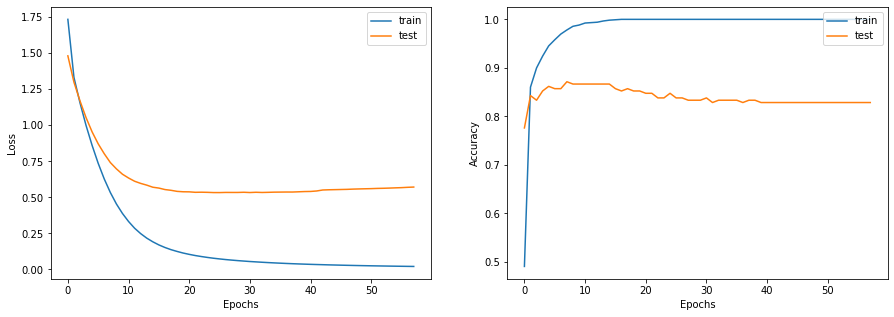

In [27]:
display_learning_curves(history)

In [28]:
x_test = test_data.paper_id.to_numpy()
_, test_accuracy = gcn_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 85.34%


In [29]:
# First we add the N new_instances as nodes to the graph
# by appending the new_instance to node_features.
num_nodes = node_features.shape[0]
new_node_features = np.concatenate([node_features, new_instances])
# Second we add the M edges (citations) from each new node to a set
# of existing nodes in a particular subject
new_node_indices = [i + num_nodes for i in range(num_classes)]
new_citations = []
for subject_idx, group in papers.groupby("subject"):
    subject_papers = list(group.paper_id)
    # Select random x papers specific subject.
    selected_paper_indices1 = np.random.choice(subject_papers, 5)
    # Select random y papers from any subject (where y < x).
    selected_paper_indices2 = np.random.choice(list(papers.paper_id), 2)
    # Merge the selected paper indices.
    selected_paper_indices = np.concatenate(
        [selected_paper_indices1, selected_paper_indices2], axis=0
    )
    # Create edges between a citing paper idx and the selected cited papers.
    citing_paper_indx = new_node_indices[subject_idx]
    for cited_paper_idx in selected_paper_indices:
        new_citations.append([citing_paper_indx, cited_paper_idx])

new_citations = np.array(new_citations).T
new_edges = np.concatenate([edges, new_citations], axis=1)

In [31]:
print("Original node_features shape:", gcn_model.node_features.shape)
print("Original edges shape:", gcn_model.edges.shape)
gcn_model.node_features = new_node_features
gcn_model.edges = new_edges
gcn_model.edge_weights = tf.ones(shape=new_edges.shape[1])
print("New node_features shape:", gcn_model.node_features.shape)
print("New edges shape:", gcn_model.edges.shape)

logits = gcn_model.predict(tf.convert_to_tensor(new_node_indices))
probabilities = keras.activations.softmax(tf.convert_to_tensor(logits)).numpy()
display_class_probabilities(probabilities)

Original node_features shape: (2708, 1433)
Original edges shape: (2, 5429)
New node_features shape: (2715, 1433)
New edges shape: (2, 5478)
Instance 1:
- Case_Based: 54.62%
- Genetic_Algorithms: 5.6%
- Neural_Networks: 5.12%
- Probabilistic_Methods: 9.03%
- Reinforcement_Learning: 5.24%
- Rule_Learning: 9.89%
- Theory: 10.49%
Instance 2:
- Case_Based: 4.09%
- Genetic_Algorithms: 70.55%
- Neural_Networks: 8.44%
- Probabilistic_Methods: 5.91%
- Reinforcement_Learning: 3.61%
- Rule_Learning: 2.88%
- Theory: 4.51%
Instance 3:
- Case_Based: 3.15%
- Genetic_Algorithms: 4.01%
- Neural_Networks: 73.37%
- Probabilistic_Methods: 4.92%
- Reinforcement_Learning: 3.73%
- Rule_Learning: 3.67%
- Theory: 7.14%
Instance 4:
- Case_Based: 4.02%
- Genetic_Algorithms: 6.23%
- Neural_Networks: 9.2%
- Probabilistic_Methods: 71.06%
- Reinforcement_Learning: 3.79%
- Rule_Learning: 3.24%
- Theory: 2.46%
Instance 5:
- Case_Based: 6.03%
- Genetic_Algorithms: 19.08%
- Neural_Networks: 13.9%
- Probabilistic_Methods